In [8]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import omegaconf

import os
import csv, time
import pickle as pkl
import math
import random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
from jax.scipy.stats import gaussian_kde
# from jax.test_util import check_grads

import numpy as np
from functools import partial
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf
from lfiax.utils.oed_losses import lf_pce_eig_scan, lf_ace_eig_scan
from lfiax.utils.simulators import sim_linear_data_vmap, sim_linear_data_vmap_theta
from lfiax.flows.nsf import make_nsf
from lfiax.utils.simulators import sim_linear_data_vmap_theta
from lfiax.utils.utils import plot_prior_posterior, save_posterior_marginal
from lfiax.utils.utils import standard_scale, inverse_standard_scale

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
    Callable,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


In [4]:
def make_lin_reg_prior():
    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**1) * jnp.ones(theta_shape)

    prior = distrax.Independent(
        distrax.MultivariateNormalDiag(mu, sigma)
    )
    return prior

In [178]:
# Unpickling the weights and optimizer state to check things out
# Load the objects.
with open("lf_pce_best_10D_params.pkl", "rb") as f:
    loaded_objects = pkl.load(f)

# Retrieve the loaded objects.
flow_params = loaded_objects['flow_params']
xi_params = loaded_objects['xi_params']

In [179]:
# likelihood flow's params
hidden_size = 128
mlp_num_layers = 4 # default is 4
num_bins = 4 # Default is 4
flow_num_layers = 5 # CHANGED from default of 5
theta_shape = (2,)
EVENT_SHAPE = (xi_params['xi'].shape[0],)
xi_shape = (xi_params['xi'].shape[0],)

# TODO: reduce boilerplate code.
# @hk.transform_with_state
@hk.without_apply_rng
@hk.transform
def log_prob(x: Array, theta: Array, xi: Array) -> Array:
    # TODO: Pass more nsf parameters from config.yaml
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_theta=True,  # Play around with not normalizing
        use_resnet=True,
        conditional=True
    )
    return model.log_prob(x, theta, xi)


In [180]:
# TODO: test out with some different seeds
prng_seq = hk.PRNGSequence(10)
priors = make_lin_reg_prior()
prior_samples, prior_log_prob = priors.sample_and_log_prob(seed=next(prng_seq), sample_shape=(10_000,))

prior_shift = jnp.mean(prior_samples, axis=0)
prior_scale = jnp.std(prior_samples, axis=0)

x_mean_shift, _, _ = sim_linear_data_vmap_theta(xi_params['xi'], prior_samples, next(prng_seq))

x_mean_norm1 = jnp.mean(x_mean_shift, axis=0)
x_scale_norm1 = jnp.std(x_mean_shift, axis=0)

true_theta = jnp.array([[5,2]])
d_sim = xi_params['xi']
sim_samples = 10_000

prior_samples = priors.sample(seed=next(prng_seq), sample_shape=(sim_samples,))
x_obs, _, _ = sim_linear_data_vmap_theta(d_sim, true_theta, next(prng_seq))

x_obs_scale = (x_obs - x_mean_norm1) / x_scale_norm1

In [181]:
jnp.std(x_mean_shift)

DeviceArray(14.199429, dtype=float32)

In [182]:
x_obs

DeviceArray([[ -1.7816558,  21.513535 ,   5.047468 ,  -5.053189 ,
               -7.3322906,  59.123215 ,  38.509266 ,  -9.452639 ,
               -1.7029586, -27.84386  ]], dtype=float32)

In [183]:
x_obs_scale.squeeze()

DeviceArray([-0.9461597 ,  1.7215264 ,  0.20356382, -1.5958428 ,
             -1.0329332 ,  2.0802248 ,  1.751347  , -1.4542985 ,
             -0.8263003 , -1.5193695 ], dtype=float32)

In [184]:
xi_params['xi']/10.

array([-0.15680042,  0.31007785, -0.05774839, -0.12969536, -0.3453905 ,
        0.87600344,  0.64417833, -0.2818004 , -0.19104987, -0.6941224 ],
      dtype=float32)

In [185]:
xi_test = jnp.broadcast_to(
    xi_params['xi']/10., (len(prior_samples), xi_params['xi'].shape[-1]))

x_obs_test = jnp.broadcast_to(
    x_obs_scale.squeeze(0), (len(prior_samples), x_obs_scale.shape[-1]))

# Getting the posterior by adding the log_probs fo likelihood and prior
liklelihoods = log_prob.apply(flow_params, x_obs_test, prior_samples, xi_test)

log_posterior = liklelihoods + prior_log_prob

# Compute the maximum log-posterior
max_log_posterior = jnp.max(log_posterior)

# Subtract the max log_posterior from each log_posterior to avoid underflow
adjusted_log_posterior = log_posterior - max_log_posterior

# Exponentiate the adjusted log-posteriors to get the unnormalized posterior weights
unnormalized_posterior_weights = jnp.exp(adjusted_log_posterior)

# Normalize the posterior weights
posterior_weights = unnormalized_posterior_weights / jnp.sum(unnormalized_posterior_weights)

# OLD
# # Exponentiate the log-posterior weights to get the unnormalized posterior weights
# unnormalized_posterior_weights = jnp.exp(log_posterior)

# # Normalize the posterior weights
# posterior_weights = unnormalized_posterior_weights / jnp.sum(unnormalized_posterior_weights)

# key = jrandom.PRNGKey(0)
posterior_samples = jrandom.choice(next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=posterior_weights)


# Better method for getting posterior samples
log_unnormalized_posterior_weights = log_posterior
max_log_weight = jnp.max(log_unnormalized_posterior_weights)
log_posterior_weights_shifted = log_unnormalized_posterior_weights - max_log_weight
unnormalized_posterior_weights = jnp.exp(log_posterior_weights_shifted)
# Normalize the posterior weights
posterior_weights2 = unnormalized_posterior_weights / jnp.sum(unnormalized_posterior_weights)
posterior_samples2 = jrandom.choice(next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=posterior_weights2)

In [186]:
jnp.exp(liklelihoods)

DeviceArray([9.46412147e-17, 8.24486141e-27, 3.58264976e-25, ...,
             1.13489844e-26, 4.88349275e-16, 2.70230466e-25],            dtype=float32)

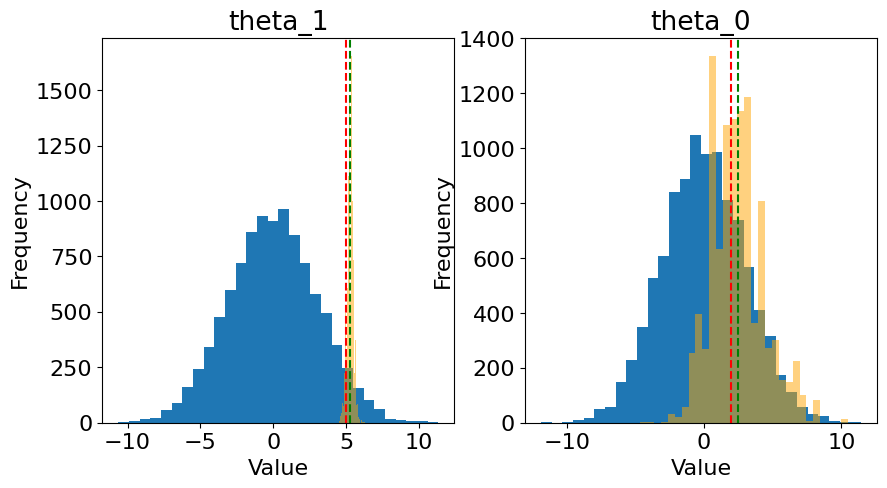

In [187]:
plot_prior_posterior(prior_samples, posterior_samples, true_theta, 'test_lfpce.png')

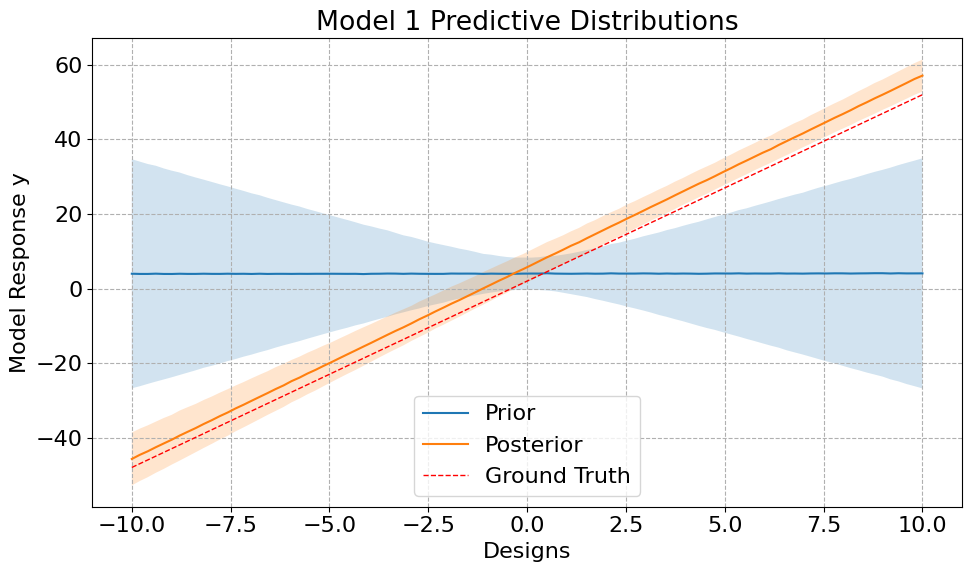

In [177]:
design_space = jnp.linspace(-10, 10, 100)

data_prior = list()
for d_space in design_space:
    
    d = jnp.array([[d_space]])

    y, _, _ = sim_linear_data_vmap_theta(d, prior_samples, next(prng_seq))
    data_prior.append(y)
data_prior = jnp.array(data_prior)


data_post = list()
for d_space in design_space:
    
    d = jnp.array([[d_space]])

    y, _, _ = sim_linear_data_vmap_theta(d, posterior_samples, next(prng_seq))
    data_post.append(y)
data_post = jnp.array(data_post)



mean_data_1 = jnp.mean(data_prior, axis=2).reshape(-1)
std_data_1 = jnp.std(data_prior, axis=2).reshape(-1)

mean_data_1_post = jnp.mean(data_post, axis=2).reshape(-1)
std_data_1_post = jnp.std(data_post, axis=2).reshape(-1)


%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})

# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))

# MODEL 1

ax = fig.add_subplot(111)

ax.plot(design_space, mean_data_1, label='Prior')
ax.fill_between(design_space, mean_data_1 - std_data_1, mean_data_1 + std_data_1, alpha=0.2)
ax.plot(design_space, mean_data_1_post, label='Posterior')
ax.fill_between(design_space, mean_data_1_post - std_data_1_post, mean_data_1_post + std_data_1_post, alpha=0.2)
xx = jnp.linspace(-10, 10, 1000)
ax.plot(xx, 2 + 5*xx, ls='--', c='r', lw=1, label='Ground Truth')

ax.set_xlabel('Designs')
ax.set_ylabel('Model Response y')
ax.set_title('Model 1 Predictive Distributions')
ax.legend(loc='lower center')
ax.grid(True, ls='--')

plt.tight_layout()



In [154]:
# Checking out flow's params to see if I can figure out conditonal net's input for 100D xi
flow_params['conditioner_module/mlp/~/linear_0']['w'].shape

(202, 128)